# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 100

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_AdamW'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../../data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = ExponentialLR(optimizer, gamma=0.95)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.001

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100] :


1 Train: 100%|███████| 391/391 [00:30<00:00, 12.90it/s]

Train Loss: 1.7047 | Train Acc: 37.73%



/home/lee/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test  Loss: 1.7983 | Test Acc: 39.80%
updated best eval loss : 1.7982915790775154
--------------------------------------------------
[Epoch 2/100] :


2 Train: 100%|███████| 391/391 [00:29<00:00, 13.48it/s]


Train Loss: 1.2750 | Train Acc: 54.20%
Test  Loss: 2.1151 | Test Acc: 39.29%
--------------------------------------------------
[Epoch 3/100] :


3 Train: 100%|███████| 391/391 [00:29<00:00, 13.04it/s]


Train Loss: 1.0886 | Train Acc: 61.44%
Test  Loss: 1.3101 | Test Acc: 58.70%
updated best eval loss : 1.3101274635218367
--------------------------------------------------
[Epoch 4/100] :


4 Train: 100%|███████| 391/391 [00:29<00:00, 13.29it/s]


Train Loss: 0.9740 | Train Acc: 65.88%
Test  Loss: 1.2084 | Test Acc: 61.13%
updated best eval loss : 1.2084343674816662
--------------------------------------------------
[Epoch 5/100] :


5 Train: 100%|███████| 391/391 [00:31<00:00, 12.58it/s]


Train Loss: 0.8953 | Train Acc: 68.98%
Test  Loss: 0.8579 | Test Acc: 70.14%
updated best eval loss : 0.8578834843031967
--------------------------------------------------
[Epoch 6/100] :


6 Train: 100%|███████| 391/391 [00:30<00:00, 13.02it/s]


Train Loss: 0.8297 | Train Acc: 71.04%
Test  Loss: 0.8609 | Test Acc: 71.19%
--------------------------------------------------
[Epoch 7/100] :


7 Train: 100%|███████| 391/391 [00:30<00:00, 12.86it/s]


Train Loss: 0.7954 | Train Acc: 72.34%
Test  Loss: 1.1325 | Test Acc: 62.73%
--------------------------------------------------
[Epoch 8/100] :


8 Train: 100%|███████| 391/391 [00:31<00:00, 12.42it/s]


Train Loss: 0.7534 | Train Acc: 73.87%
Test  Loss: 1.1616 | Test Acc: 62.09%
--------------------------------------------------
[Epoch 9/100] :


9 Train: 100%|███████| 391/391 [00:33<00:00, 11.75it/s]


Train Loss: 0.7188 | Train Acc: 75.17%
Test  Loss: 0.8558 | Test Acc: 71.90%
updated best eval loss : 0.8557747300667099
--------------------------------------------------
[Epoch 10/100] :


10 Train: 100%|██████| 391/391 [00:43<00:00,  8.91it/s]


Train Loss: 0.6995 | Train Acc: 75.88%
Test  Loss: 0.6726 | Test Acc: 76.97%
updated best eval loss : 0.6726251606699787
--------------------------------------------------
[Epoch 11/100] :


11 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.6708 | Train Acc: 76.64%
Test  Loss: 0.6969 | Test Acc: 76.70%
--------------------------------------------------
[Epoch 12/100] :


12 Train: 100%|██████| 391/391 [00:40<00:00,  9.74it/s]


Train Loss: 0.6461 | Train Acc: 77.26%
Test  Loss: 0.6098 | Test Acc: 79.58%
updated best eval loss : 0.6098053164874451
--------------------------------------------------
[Epoch 13/100] :


13 Train: 100%|██████| 391/391 [00:37<00:00, 10.30it/s]


Train Loss: 0.6317 | Train Acc: 77.84%
Test  Loss: 0.6969 | Test Acc: 75.73%
--------------------------------------------------
[Epoch 14/100] :


14 Train: 100%|██████| 391/391 [00:35<00:00, 11.16it/s]


Train Loss: 0.6107 | Train Acc: 78.64%
Test  Loss: 0.6473 | Test Acc: 78.81%
--------------------------------------------------
[Epoch 15/100] :


15 Train: 100%|██████| 391/391 [00:33<00:00, 11.78it/s]


Train Loss: 0.5968 | Train Acc: 79.25%
Test  Loss: 0.8615 | Test Acc: 72.36%
--------------------------------------------------
[Epoch 16/100] :


16 Train: 100%|██████| 391/391 [00:34<00:00, 11.21it/s]


Train Loss: 0.5858 | Train Acc: 79.63%
Test  Loss: 0.7765 | Test Acc: 74.40%
--------------------------------------------------
[Epoch 17/100] :


17 Train: 100%|██████| 391/391 [00:35<00:00, 11.01it/s]


Train Loss: 0.5610 | Train Acc: 80.41%
Test  Loss: 0.5954 | Test Acc: 79.95%
updated best eval loss : 0.5953890862344187
--------------------------------------------------
[Epoch 18/100] :


18 Train: 100%|██████| 391/391 [00:34<00:00, 11.42it/s]


Train Loss: 0.5586 | Train Acc: 80.50%
Test  Loss: 0.5696 | Test Acc: 80.83%
updated best eval loss : 0.5695619915105119
--------------------------------------------------
[Epoch 19/100] :


19 Train: 100%|██████| 391/391 [00:35<00:00, 11.08it/s]


Train Loss: 0.5435 | Train Acc: 81.19%
Test  Loss: 0.5709 | Test Acc: 80.50%
--------------------------------------------------
[Epoch 20/100] :


20 Train: 100%|██████| 391/391 [00:33<00:00, 11.64it/s]


Train Loss: 0.5385 | Train Acc: 81.31%
Test  Loss: 0.5865 | Test Acc: 80.13%
--------------------------------------------------
[Epoch 21/100] :


21 Train: 100%|██████| 391/391 [00:33<00:00, 11.74it/s]


Train Loss: 0.5186 | Train Acc: 81.98%
Test  Loss: 0.5492 | Test Acc: 81.61%
updated best eval loss : 0.549248830804342
--------------------------------------------------
[Epoch 22/100] :


22 Train: 100%|██████| 391/391 [00:36<00:00, 10.68it/s]


Train Loss: 0.5185 | Train Acc: 81.98%
Test  Loss: 0.5285 | Test Acc: 82.14%
updated best eval loss : 0.5284786684603631
--------------------------------------------------
[Epoch 23/100] :


23 Train: 100%|██████| 391/391 [00:50<00:00,  7.68it/s]


Train Loss: 0.5032 | Train Acc: 82.51%
Test  Loss: 0.5713 | Test Acc: 80.45%
--------------------------------------------------
[Epoch 24/100] :


24 Train: 100%|██████| 391/391 [00:47<00:00,  8.32it/s]


Train Loss: 0.4937 | Train Acc: 82.82%
Test  Loss: 0.5427 | Test Acc: 81.80%
--------------------------------------------------
[Epoch 25/100] :


25 Train: 100%|██████| 391/391 [00:50<00:00,  7.77it/s]


Train Loss: 0.4894 | Train Acc: 82.89%
Test  Loss: 0.6099 | Test Acc: 80.69%
--------------------------------------------------
[Epoch 26/100] :


26 Train: 100%|██████| 391/391 [00:47<00:00,  8.26it/s]


Train Loss: 0.4817 | Train Acc: 83.33%
Test  Loss: 0.6266 | Test Acc: 79.95%
--------------------------------------------------
[Epoch 27/100] :


27 Train: 100%|██████| 391/391 [00:50<00:00,  7.77it/s]


Train Loss: 0.4766 | Train Acc: 83.46%
Test  Loss: 0.5209 | Test Acc: 82.50%
updated best eval loss : 0.5209084424791457
--------------------------------------------------
[Epoch 28/100] :


28 Train: 100%|██████| 391/391 [00:48<00:00,  8.02it/s]


Train Loss: 0.4640 | Train Acc: 83.78%
Test  Loss: 0.4529 | Test Acc: 85.08%
updated best eval loss : 0.4529399211648144
--------------------------------------------------
[Epoch 29/100] :


29 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.4591 | Train Acc: 83.92%
Test  Loss: 0.6772 | Test Acc: 78.53%
--------------------------------------------------
[Epoch 30/100] :


30 Train: 100%|██████| 391/391 [00:48<00:00,  8.10it/s]


Train Loss: 0.4503 | Train Acc: 84.25%
Test  Loss: 0.6263 | Test Acc: 80.58%
--------------------------------------------------
[Epoch 31/100] :


31 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.4432 | Train Acc: 84.45%
Test  Loss: 0.5797 | Test Acc: 80.58%
--------------------------------------------------
[Epoch 32/100] :


32 Train: 100%|██████| 391/391 [00:49<00:00,  7.86it/s]


Train Loss: 0.4394 | Train Acc: 84.67%
Test  Loss: 0.5068 | Test Acc: 82.70%
--------------------------------------------------
[Epoch 33/100] :


33 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.4364 | Train Acc: 84.80%
Test  Loss: 0.5287 | Test Acc: 82.26%
--------------------------------------------------
[Epoch 34/100] :


34 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.4309 | Train Acc: 84.89%
Test  Loss: 0.4905 | Test Acc: 84.00%
--------------------------------------------------
[Epoch 35/100] :


35 Train: 100%|██████| 391/391 [00:48<00:00,  8.07it/s]


Train Loss: 0.4203 | Train Acc: 85.30%
Test  Loss: 0.4474 | Test Acc: 85.02%
updated best eval loss : 0.44744313819498954
--------------------------------------------------
[Epoch 36/100] :


36 Train: 100%|██████| 391/391 [00:51<00:00,  7.61it/s]


Train Loss: 0.4138 | Train Acc: 85.59%
Test  Loss: 0.4626 | Test Acc: 85.05%
--------------------------------------------------
[Epoch 37/100] :


37 Train: 100%|██████| 391/391 [00:47<00:00,  8.29it/s]


Train Loss: 0.4173 | Train Acc: 85.34%
Test  Loss: 0.4776 | Test Acc: 84.20%
--------------------------------------------------
[Epoch 38/100] :


38 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.4077 | Train Acc: 85.76%
Test  Loss: 0.4721 | Test Acc: 84.38%
--------------------------------------------------
[Epoch 39/100] :


39 Train: 100%|██████| 391/391 [00:48<00:00,  8.13it/s]


Train Loss: 0.4075 | Train Acc: 85.80%
Test  Loss: 0.4354 | Test Acc: 85.60%
updated best eval loss : 0.4353728520719311
--------------------------------------------------
[Epoch 40/100] :


40 Train: 100%|██████| 391/391 [00:50<00:00,  7.80it/s]


Train Loss: 0.4007 | Train Acc: 86.01%
Test  Loss: 0.5340 | Test Acc: 82.72%
--------------------------------------------------
[Epoch 41/100] :


41 Train: 100%|██████| 391/391 [00:48<00:00,  7.98it/s]


Train Loss: 0.3928 | Train Acc: 86.18%
Test  Loss: 0.4532 | Test Acc: 85.24%
--------------------------------------------------
[Epoch 42/100] :


42 Train: 100%|██████| 391/391 [00:48<00:00,  8.10it/s]


Train Loss: 0.3889 | Train Acc: 86.35%
Test  Loss: 0.4410 | Test Acc: 85.58%
--------------------------------------------------
[Epoch 43/100] :


43 Train: 100%|██████| 391/391 [00:49<00:00,  7.86it/s]


Train Loss: 0.3849 | Train Acc: 86.29%
Test  Loss: 0.4687 | Test Acc: 84.99%
--------------------------------------------------
[Epoch 44/100] :


44 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.3839 | Train Acc: 86.61%
Test  Loss: 0.5111 | Test Acc: 83.81%
--------------------------------------------------
[Epoch 45/100] :


45 Train: 100%|██████| 391/391 [00:51<00:00,  7.60it/s]


Train Loss: 0.3809 | Train Acc: 86.63%
Test  Loss: 0.4182 | Test Acc: 86.06%
updated best eval loss : 0.41824907102162323
--------------------------------------------------
[Epoch 46/100] :


46 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.3766 | Train Acc: 86.90%
Test  Loss: 0.4258 | Test Acc: 85.88%
--------------------------------------------------
[Epoch 47/100] :


47 Train: 100%|██████| 391/391 [00:49<00:00,  7.89it/s]


Train Loss: 0.3754 | Train Acc: 86.96%
Test  Loss: 0.4407 | Test Acc: 85.75%
--------------------------------------------------
[Epoch 48/100] :


48 Train: 100%|██████| 391/391 [00:47<00:00,  8.28it/s]


Train Loss: 0.3628 | Train Acc: 87.32%
Test  Loss: 0.4725 | Test Acc: 84.71%
--------------------------------------------------
[Epoch 49/100] :


49 Train: 100%|██████| 391/391 [00:50<00:00,  7.72it/s]


Train Loss: 0.3641 | Train Acc: 87.30%
Test  Loss: 0.4191 | Test Acc: 86.72%
--------------------------------------------------
[Epoch 50/100] :


50 Train: 100%|██████| 391/391 [00:48<00:00,  8.02it/s]


Train Loss: 0.3700 | Train Acc: 87.04%
Test  Loss: 0.4694 | Test Acc: 84.78%
--------------------------------------------------
[Epoch 51/100] :


51 Train: 100%|██████| 391/391 [00:51<00:00,  7.62it/s]


Train Loss: 0.3594 | Train Acc: 87.36%
Test  Loss: 0.4812 | Test Acc: 84.68%
--------------------------------------------------
[Epoch 52/100] :


52 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.3571 | Train Acc: 87.44%
Test  Loss: 0.4858 | Test Acc: 84.46%
--------------------------------------------------
[Epoch 53/100] :


53 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.3542 | Train Acc: 87.71%
Test  Loss: 0.4533 | Test Acc: 85.83%
--------------------------------------------------
[Epoch 54/100] :


54 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.3537 | Train Acc: 87.63%
Test  Loss: 0.4460 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 55/100] :


55 Train: 100%|██████| 391/391 [00:48<00:00,  8.05it/s]


Train Loss: 0.3433 | Train Acc: 88.00%
Test  Loss: 0.5173 | Test Acc: 84.06%
--------------------------------------------------
[Epoch 56/100] :


56 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3401 | Train Acc: 88.13%
Test  Loss: 0.4436 | Test Acc: 85.59%
--------------------------------------------------
[Epoch 57/100] :


57 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.3432 | Train Acc: 87.88%
Test  Loss: 0.4453 | Test Acc: 85.78%
--------------------------------------------------
[Epoch 58/100] :


58 Train: 100%|██████| 391/391 [00:47<00:00,  8.24it/s]


Train Loss: 0.3373 | Train Acc: 88.23%
Test  Loss: 0.4664 | Test Acc: 85.18%
--------------------------------------------------
[Epoch 59/100] :


59 Train: 100%|██████| 391/391 [00:49<00:00,  7.85it/s]


Train Loss: 0.3324 | Train Acc: 88.27%
Test  Loss: 0.4284 | Test Acc: 85.97%
--------------------------------------------------
[Epoch 60/100] :


60 Train: 100%|██████| 391/391 [00:49<00:00,  7.98it/s]


Train Loss: 0.3334 | Train Acc: 88.48%
Test  Loss: 0.4389 | Test Acc: 86.34%
--------------------------------------------------
[Epoch 61/100] :


61 Train: 100%|██████| 391/391 [00:47<00:00,  8.30it/s]


Train Loss: 0.3270 | Train Acc: 88.55%
Test  Loss: 0.4054 | Test Acc: 86.76%
updated best eval loss : 0.40544834676422653
--------------------------------------------------
[Epoch 62/100] :


62 Train: 100%|██████| 391/391 [00:49<00:00,  7.82it/s]


Train Loss: 0.3284 | Train Acc: 88.58%
Test  Loss: 0.4713 | Test Acc: 84.84%
--------------------------------------------------
[Epoch 63/100] :


63 Train: 100%|██████| 391/391 [00:49<00:00,  7.96it/s]


Train Loss: 0.3247 | Train Acc: 88.71%
Test  Loss: 0.4780 | Test Acc: 84.11%
--------------------------------------------------
[Epoch 64/100] :


64 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.3204 | Train Acc: 88.70%
Test  Loss: 0.4753 | Test Acc: 84.49%
--------------------------------------------------
[Epoch 65/100] :


65 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.3244 | Train Acc: 88.74%
Test  Loss: 0.3944 | Test Acc: 87.36%
updated best eval loss : 0.3944176516578167
--------------------------------------------------
[Epoch 66/100] :


66 Train: 100%|██████| 391/391 [00:49<00:00,  7.95it/s]


Train Loss: 0.3217 | Train Acc: 88.68%
Test  Loss: 0.4569 | Test Acc: 85.32%
--------------------------------------------------
[Epoch 67/100] :


67 Train: 100%|██████| 391/391 [00:49<00:00,  7.88it/s]


Train Loss: 0.3154 | Train Acc: 88.97%
Test  Loss: 0.4270 | Test Acc: 85.95%
--------------------------------------------------
[Epoch 68/100] :


68 Train: 100%|██████| 391/391 [00:47<00:00,  8.17it/s]


Train Loss: 0.3144 | Train Acc: 89.08%
Test  Loss: 0.4690 | Test Acc: 84.96%
--------------------------------------------------
[Epoch 69/100] :


69 Train: 100%|██████| 391/391 [00:49<00:00,  7.94it/s]


Train Loss: 0.3107 | Train Acc: 89.14%
Test  Loss: 0.4142 | Test Acc: 87.24%
--------------------------------------------------
[Epoch 70/100] :


70 Train: 100%|██████| 391/391 [00:47<00:00,  8.19it/s]


Train Loss: 0.3140 | Train Acc: 89.07%
Test  Loss: 0.4066 | Test Acc: 86.90%
--------------------------------------------------
[Epoch 71/100] :


71 Train: 100%|██████| 391/391 [00:49<00:00,  7.87it/s]


Train Loss: 0.3066 | Train Acc: 89.14%
Test  Loss: 0.5080 | Test Acc: 83.76%
--------------------------------------------------
[Epoch 72/100] :


72 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.3080 | Train Acc: 89.26%
Test  Loss: 0.5393 | Test Acc: 83.83%
--------------------------------------------------
[Epoch 73/100] :


73 Train: 100%|██████| 391/391 [00:49<00:00,  7.85it/s]


Train Loss: 0.3029 | Train Acc: 89.31%
Test  Loss: 0.4954 | Test Acc: 84.84%
--------------------------------------------------
[Epoch 74/100] :


74 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.3065 | Train Acc: 89.30%
Test  Loss: 0.4213 | Test Acc: 86.71%
--------------------------------------------------
[Epoch 75/100] :


75 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.2994 | Train Acc: 89.48%
Test  Loss: 0.4095 | Test Acc: 86.99%
--------------------------------------------------
[Epoch 76/100] :


76 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.2996 | Train Acc: 89.46%
Test  Loss: 0.4714 | Test Acc: 85.52%
--------------------------------------------------
[Epoch 77/100] :


77 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.2990 | Train Acc: 89.51%
Test  Loss: 0.4446 | Test Acc: 86.22%
--------------------------------------------------
[Epoch 78/100] :


78 Train: 100%|██████| 391/391 [00:48<00:00,  8.07it/s]


Train Loss: 0.2971 | Train Acc: 89.69%
Test  Loss: 0.3991 | Test Acc: 87.90%
--------------------------------------------------
[Epoch 79/100] :


79 Train: 100%|██████| 391/391 [00:48<00:00,  7.99it/s]


Train Loss: 0.2912 | Train Acc: 89.88%
Test  Loss: 0.4422 | Test Acc: 86.18%
--------------------------------------------------
[Epoch 80/100] :


80 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.2907 | Train Acc: 89.85%
Test  Loss: 0.4209 | Test Acc: 86.71%
--------------------------------------------------
[Epoch 81/100] :


81 Train: 100%|██████| 391/391 [00:49<00:00,  7.90it/s]


Train Loss: 0.2856 | Train Acc: 89.87%
Test  Loss: 0.4570 | Test Acc: 85.87%
--------------------------------------------------
[Epoch 82/100] :


82 Train: 100%|██████| 391/391 [00:50<00:00,  7.73it/s]


Train Loss: 0.2893 | Train Acc: 89.96%
Test  Loss: 0.4347 | Test Acc: 86.50%
--------------------------------------------------
[Epoch 83/100] :


83 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.2904 | Train Acc: 89.79%
Test  Loss: 0.4726 | Test Acc: 85.68%
--------------------------------------------------
[Epoch 84/100] :


84 Train: 100%|██████| 391/391 [00:51<00:00,  7.54it/s]


Train Loss: 0.2801 | Train Acc: 90.27%
Test  Loss: 0.4659 | Test Acc: 85.69%
--------------------------------------------------
[Epoch 85/100] :


85 Train: 100%|██████| 391/391 [00:48<00:00,  8.09it/s]


Train Loss: 0.2844 | Train Acc: 90.07%
Test  Loss: 0.4396 | Test Acc: 86.48%
--------------------------------------------------
[Epoch 86/100] :


86 Train: 100%|██████| 391/391 [00:49<00:00,  7.92it/s]


Train Loss: 0.2797 | Train Acc: 90.25%
Test  Loss: 0.4285 | Test Acc: 86.82%
--------------------------------------------------
[Epoch 87/100] :


87 Train: 100%|██████| 391/391 [00:48<00:00,  8.08it/s]


Train Loss: 0.2792 | Train Acc: 90.17%
Test  Loss: 0.4117 | Test Acc: 87.26%
--------------------------------------------------
[Epoch 88/100] :


88 Train: 100%|██████| 391/391 [00:48<00:00,  8.03it/s]


Train Loss: 0.2790 | Train Acc: 90.21%
Test  Loss: 0.4289 | Test Acc: 86.64%
--------------------------------------------------
[Epoch 89/100] :


89 Train: 100%|██████| 391/391 [00:49<00:00,  7.97it/s]


Train Loss: 0.2783 | Train Acc: 90.22%
Test  Loss: 0.4436 | Test Acc: 87.00%
--------------------------------------------------
[Epoch 90/100] :


90 Train: 100%|██████| 391/391 [00:50<00:00,  7.80it/s]


Train Loss: 0.2760 | Train Acc: 90.23%
Test  Loss: 0.4057 | Test Acc: 87.24%
--------------------------------------------------
[Epoch 91/100] :


91 Train: 100%|██████| 391/391 [00:49<00:00,  7.93it/s]


Train Loss: 0.2815 | Train Acc: 90.22%
Test  Loss: 0.4231 | Test Acc: 86.42%
--------------------------------------------------
[Epoch 92/100] :


92 Train: 100%|██████| 391/391 [00:48<00:00,  8.04it/s]


Train Loss: 0.2728 | Train Acc: 90.60%
Test  Loss: 0.3923 | Test Acc: 87.47%
updated best eval loss : 0.3923153528307058
--------------------------------------------------
[Epoch 93/100] :


93 Train: 100%|██████| 391/391 [00:48<00:00,  8.11it/s]


Train Loss: 0.2718 | Train Acc: 90.50%
Test  Loss: 0.4205 | Test Acc: 87.54%
--------------------------------------------------
[Epoch 94/100] :


94 Train: 100%|██████| 391/391 [00:47<00:00,  8.23it/s]


Train Loss: 0.2725 | Train Acc: 90.43%
Test  Loss: 0.4550 | Test Acc: 86.15%
--------------------------------------------------
[Epoch 95/100] :


95 Train: 100%|██████| 391/391 [00:50<00:00,  7.79it/s]


Train Loss: 0.2741 | Train Acc: 90.38%
Test  Loss: 0.4400 | Test Acc: 86.32%
--------------------------------------------------
[Epoch 96/100] :


96 Train: 100%|██████| 391/391 [00:47<00:00,  8.15it/s]


Train Loss: 0.2573 | Train Acc: 90.97%
Test  Loss: 0.3960 | Test Acc: 87.80%
--------------------------------------------------
[Epoch 97/100] :


97 Train: 100%|██████| 391/391 [00:49<00:00,  7.94it/s]


Train Loss: 0.2680 | Train Acc: 90.61%
Test  Loss: 0.4053 | Test Acc: 87.49%
--------------------------------------------------
[Epoch 98/100] :


98 Train: 100%|██████| 391/391 [00:37<00:00, 10.31it/s]


Train Loss: 0.2659 | Train Acc: 90.69%
Test  Loss: 0.3692 | Test Acc: 88.50%
updated best eval loss : 0.36921873858457877
--------------------------------------------------
[Epoch 99/100] :


99 Train: 100%|██████| 391/391 [00:39<00:00,  9.81it/s]


Train Loss: 0.2585 | Train Acc: 90.90%
Test  Loss: 0.4943 | Test Acc: 85.52%
--------------------------------------------------
[Epoch 100/100] :


100 Train: 100%|█████| 391/391 [00:33<00:00, 11.79it/s]


Train Loss: 0.2685 | Train Acc: 90.52%
Test  Loss: 0.4107 | Test Acc: 87.38%
--------------------------------------------------


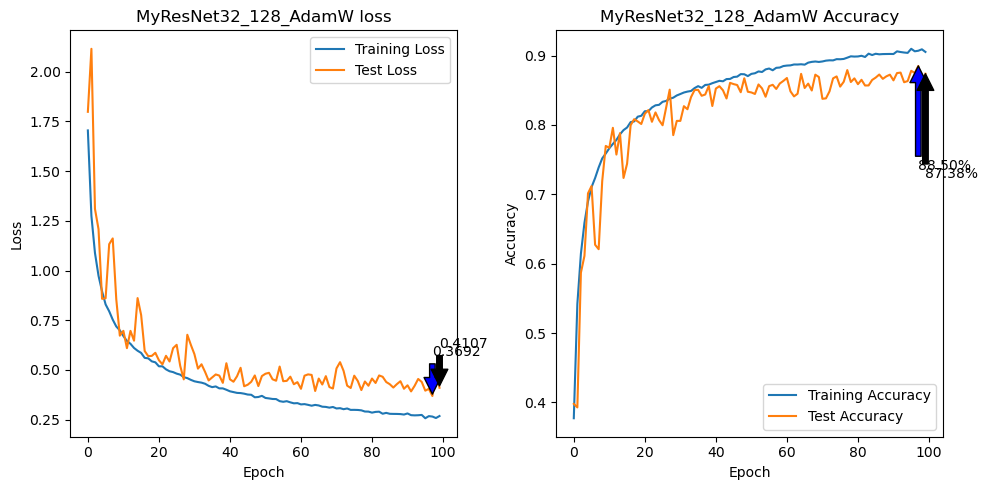

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=1.7047, train_acc=0.3773, test_loss=1.7983, test_acc=0.3980, lr=0.0010
2 epoch: train_loss=1.2750, train_acc=0.5420, test_loss=2.1151, test_acc=0.3929, lr=0.0010
3 epoch: train_loss=1.0886, train_acc=0.6144, test_loss=1.3101, test_acc=0.5870, lr=0.0010
4 epoch: train_loss=0.9740, train_acc=0.6588, test_loss=1.2084, test_acc=0.6113, lr=0.0010
5 epoch: train_loss=0.8953, train_acc=0.6898, test_loss=0.8579, test_acc=0.7014, lr=0.0010
6 epoch: train_loss=0.8297, train_acc=0.7104, test_loss=0.8609, test_acc=0.7119, lr=0.0010
7 epoch: train_loss=0.7954, train_acc=0.7234, test_loss=1.1325, test_acc=0.6273, lr=0.0010
8 epoch: train_loss=0.7534, train_acc=0.7387, test_loss=1.1616, test_acc=0.6209, lr=0.0010
9 epoch: train_loss=0.7188, train_acc=0.7517, test_loss=0.8558, test_acc=0.7190, lr=0.0010
10 epoch: train_loss=0.6995, train_acc=0.7588, test_loss=0.6726, test_acc=0.7697, lr=0.0010
11 epoch: train_loss=0.6708, train_acc=0.7664, test_loss=0.6969, test_acc=0.7670, lr=0.00